# Анализ и подготовка плана по удержанию клиентов.

Заказчик сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.  
В ходе анализа мы:


- спрогнозируем вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформируем типичные портреты клиентов;
- сформулируем основные выводы и разработаем рекомендации по повышению качества работы с клиентами:
1. выделим целевые группы клиентов;
2. предложим меры по снижению оттока.



Описание данных:


Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:


Данные клиента за предыдущий до проверки факта оттока месяц:


- *'gender'* — пол;
- *'Near_Location'* — проживание или работа в районе, где находится фитнес-центр;
- *'Partner'* — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- *Promo_friends* — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- *'Phone'* — наличие контактного телефона;
- *'Age'* — возраст;
- *'Lifetime'* — время с момента первого обращения в фитнес-центр (в месяцах).


Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:


- *'Contract_period'* — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- *'Month_to_end_contract'* — срок до окончания текущего действующего абонемента (в месяцах);
- *'Group_visits'* — факт посещения групповых занятий;
- *'Avg_class_frequency_total'* — средняя частота посещений в неделю за все время с начала действия абонемента;
- *'Avg_class_frequency_current_month'* — средняя частота посещений в неделю за предыдущий месяц;
- *'Avg_additional_charges_total'* — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- *'Churn'* — факт оттока в текущем месяце.


### Импорт библиотек.

#### Импортируем библиотеки. Считаем данные из csv-файла в датафрейм и сохраним в переменную *gym_churn*.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
gym_churn = pd.read_csv('gym_churn.csv')
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


### Предобработка данных.

#### Выведем общую информацию о таблице и ее типах данных. Проверим на наличие пропусков и дубликатов.

In [3]:
gym_churn.info()
print('Количество явных дубликатов', gym_churn.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
gym_churn.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


В таблице представлено 4000 наблюдений и 14 полей - 13 признаков и целевая переменная **Churn**, указывающая на факт оттока в текущем месяце. В данных нет пропусков и явных дубликатов.

#### Проанализируем средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [5]:
gym_churn.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


На основании таблицы можно сделать вывод, что клиенты продолжающие ходить в клуб имеют абонементы в среднем сроком на 6 месяцев, в то время в отток ушли те, у кого средний показатель длительности текущего абонемента равен 1,7. Более 45% действующих клиентов посещают групповые занятия, тот же показатель доли у клиентов покинувших клуб равен 26,8%. Средняя частота посещений в два раза больше у клиентов оставшихся, чем у тех, которые ушли в отток. Так же стоит отметить что пол и локация никак не влияет на отток клиентов.

#### Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

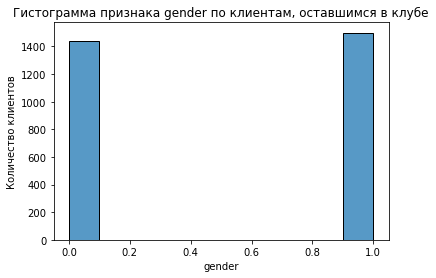

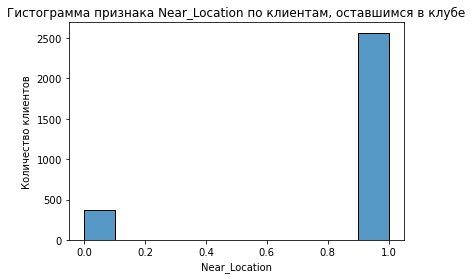

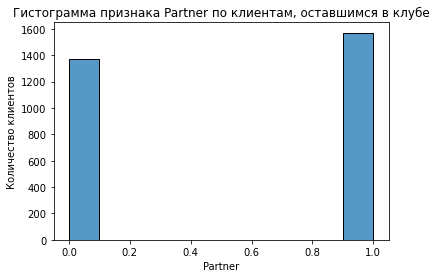

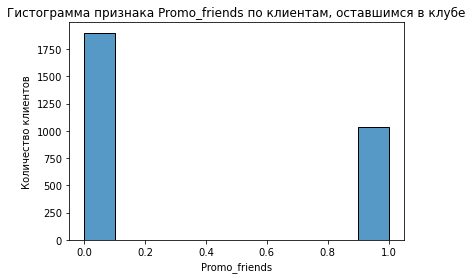

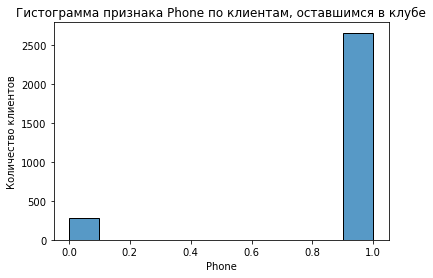

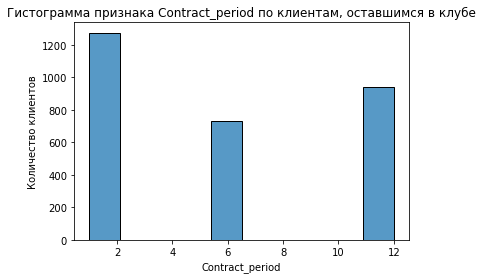

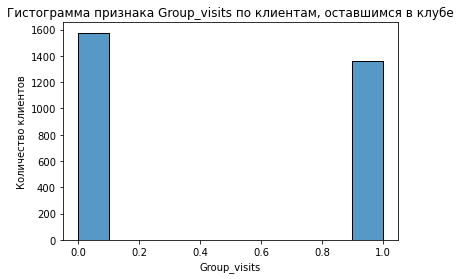

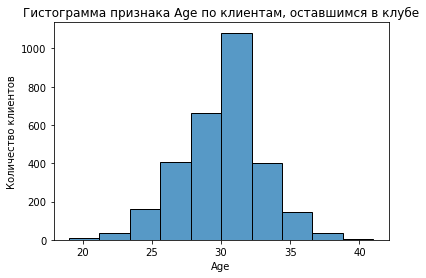

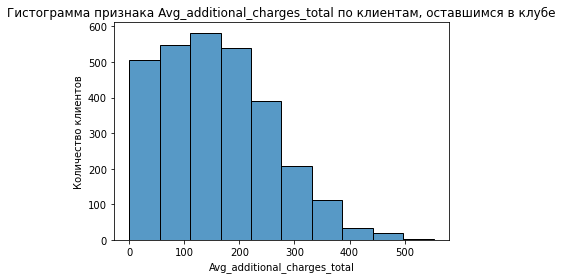

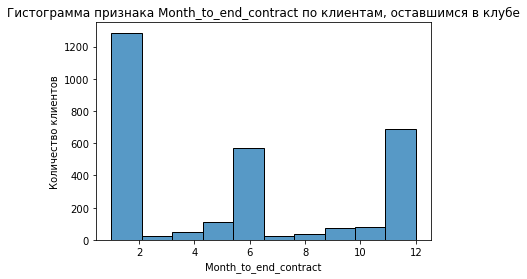

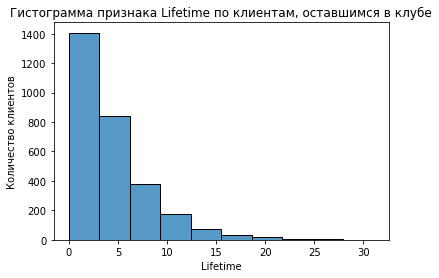

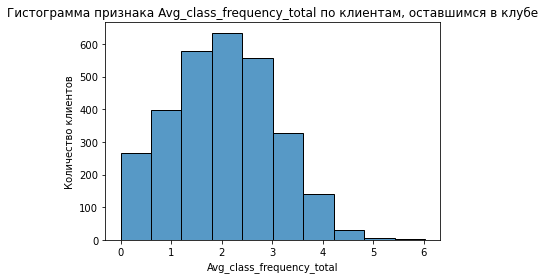

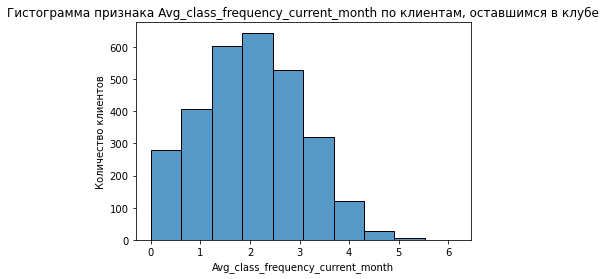

In [6]:
#создадим датафрейм только с клиентами, кто остался и удалим столбец с целевой переменной
survivor = gym_churn[gym_churn['Churn']!=1].drop('Churn', axis = 1)

#построим гистограмму для каждого признака
for name in survivor.columns:
    sns.histplot(survivor[name], bins=10)
    plt.title(f'Гистограмма признака {name} по клиентам, оставшимся в клубе')
    plt.ylabel('Количество клиентов')
    plt.show() 
    

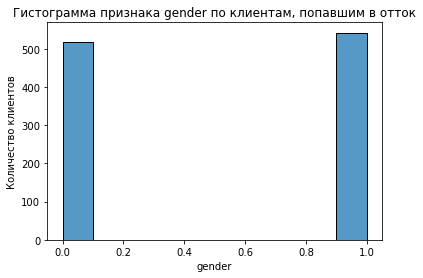

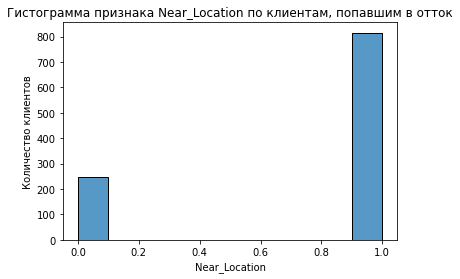

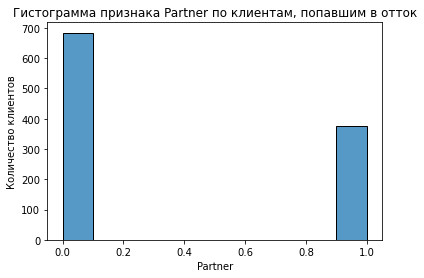

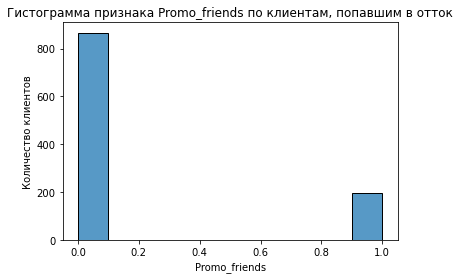

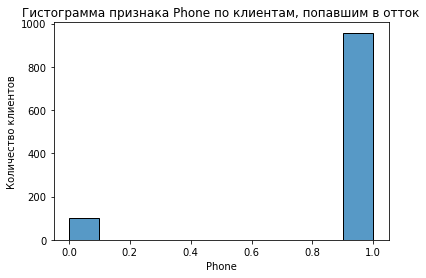

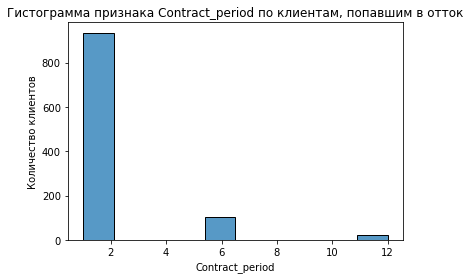

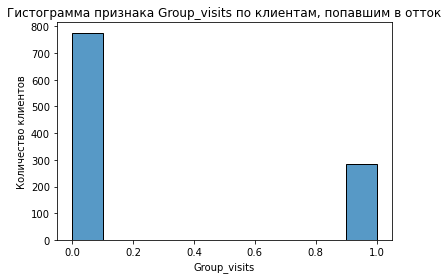

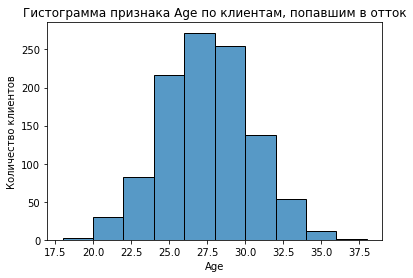

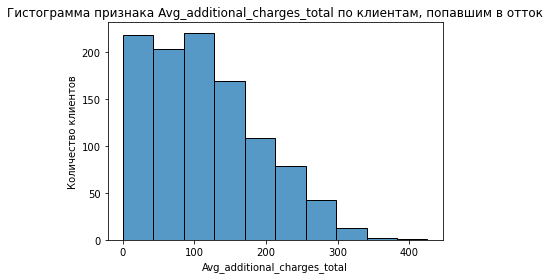

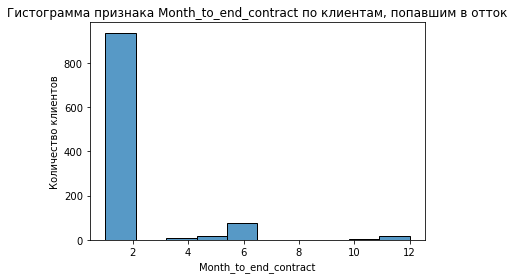

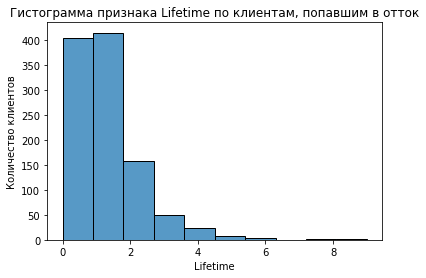

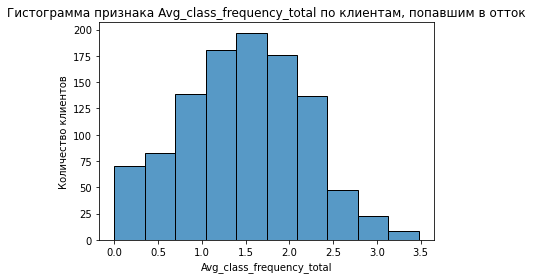

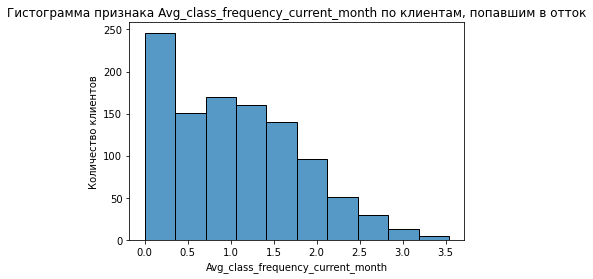

In [7]:
#создадим датафрейм только с клиентами, кто попал в отток и удалим столбец с целевой переменной
customer_churn = gym_churn[gym_churn['Churn']==1].drop('Churn', axis = 1)

#построим гистограмму для каждого признака
for name in customer_churn.columns:
    sns.histplot(customer_churn[name], bins=10)
    plt.title(f'Гистограмма признака {name} по клиентам, попавшим в отток')
    plt.ylabel('Количество клиентов')
    plt.show()

При сравнении признаков о партнерстве с клубом можно сделать вывод, что соотношение, имеющих партнерство и без него у клиентов оставшихся в клубе практически равное, а у клиентов попавших в отток нет, так практически вдвое больше клиентов, не имеющих партнерских связей с клубом. В обоих группах преобладают клиенты, купившие абономент сроком на 1 месяц, но в группе с оттоком их более 75%. Чаще всего в отток попадают клиенты, у который осталось менее двух месяцев до окончания абонемента.

#### Построим матрицу корреляций и отобразим её.

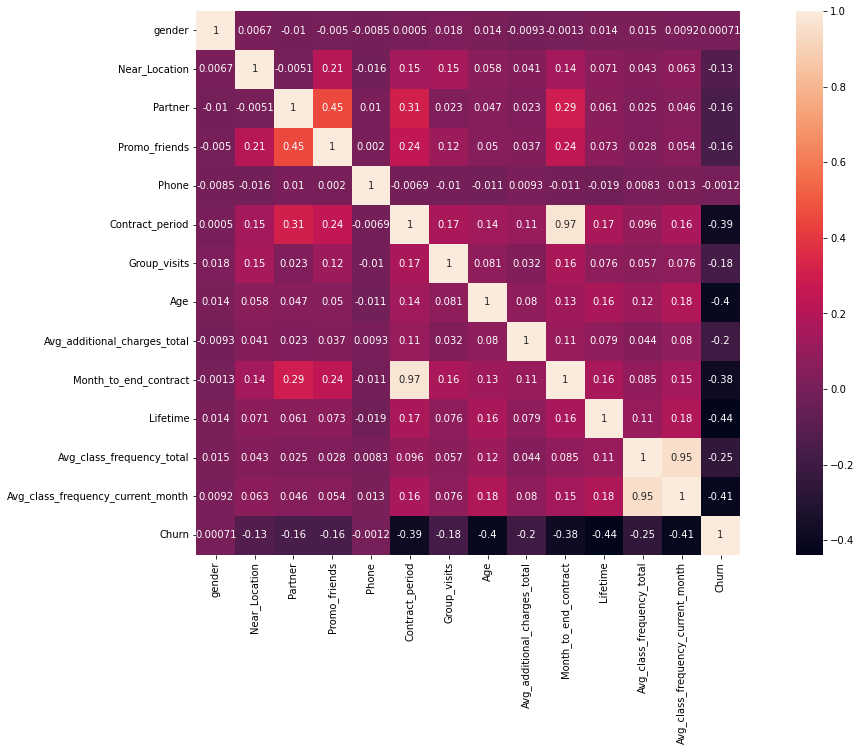

In [8]:
cm = gym_churn.corr() 
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(cm, annot=True, square=True);

По матрице можно сделать вывод о наличии двух пар скоррелированных признаков:
- средняя частота посещений в неделю за все время и за предыдущий месяц
- длительность текущего действующего абонемента и срок до окончания текущего действующего абонемента 

Мультиколлинеарность может влиять на результаты  работы линейных моделей, что необходимо учесть при необходимости.


### Модель прогнозирования оттока клиентов.

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

In [9]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop('Churn', axis = 1)
y = gym_churn['Churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(solver='liblinear', random_state=0)
# обучим модель
lr_model.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test)

# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    title='Метрики для модели логистической регрессии:',
)


# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) # Ваш код здесь
# обучим модель случайного леса
rf_model.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test) # Ваш код здесь

# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    title='Метрики для модели случайного леса:'
)


Метрики для модели логистической регрессии:
	Accuracy: 0.93
	Precision: 0.86
	Recall: 0.83
Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.82


В сравнении значений метрик  логистическая регрессия более интерпретируемая модель, чем случайный лес. Доля правильных ответов в модели регрессии равна 93%, а в модели случайного леса 92%.  Метрики точности (precision) и полноты (recall) так же в регресии показывают большую точность. Поэтому можно сделать вывод, что модель Логистической регресии показала себя лучше на основании метрик.

### Кластеризация клиентов.



#### Стандартизируем данные.

In [10]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')

#### Агломеративная иерархическая кластеризация.


Построим матрицу расстояний  на стандартизованной матрице признаков и нарисуем дендрограмму.

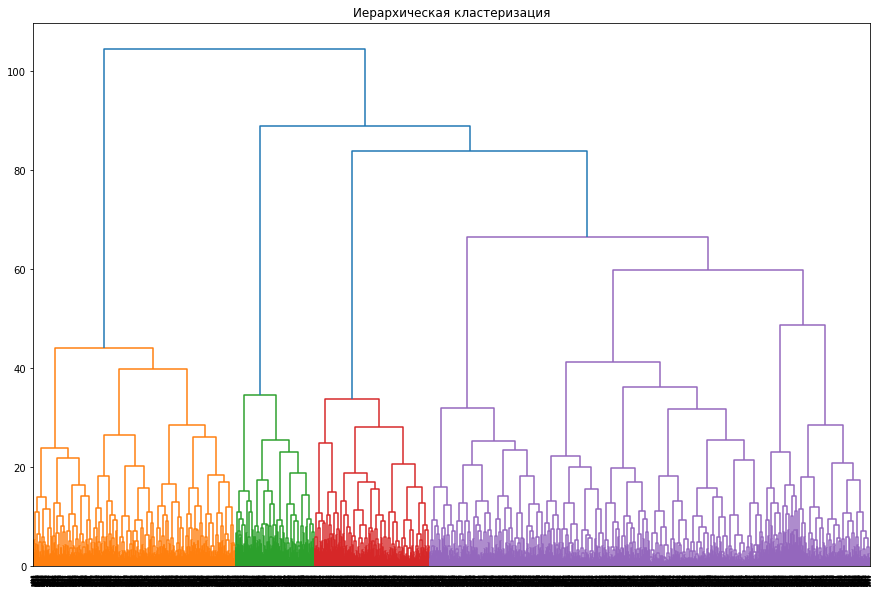

In [11]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

На основании полученного графика предположим, что можно выделить 5 кластеров. 

#### Обучим модель кластеризации на основании алгоритма K-Means.

In [12]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
gym_churn['cluster_km'] = labels

#выводим статистику по средним значениям наших признаков по кластеру
gym_churn.groupby('cluster_km').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


 Во всех кластерах доля мужчин и женщин практически одинаковая и делится в равной пропорции. В 3 кластер попали клиенты, которые не привязанные к клубу территориально, в остальных группах доля клиентов проживанющих или работающих в районе, где находится фитнес-центр 86% и выше. Менее 8% клиентов в 3 группе использовали промо-код для первичной записи в зал, а в первом кластере таких клиентов более 50%. В первоую группу попали клиенты с более длительным сроком действия абонемента. Средний возраст во всех кластерах приблизительно одинаков и варьируется от 28 до 30 лет. Так же стоит отметить, что клиенты 1 и 5 групп тратят в среднем больше, чем клиенты в остальных кластерах.
 
 
 Проанализировав долю оттока в каждом кластере, можно сделать вывод, что минимальный отток равный 2,7% у первой группы, так же незначительный отток у 5 группы равный 6,8%. Самый большой отток у 4 группы, половина клиентов покинула клуб.

#### Построим распределения признаков для кластеров. 

C:\Users\Anna\AppData\Local\Temp\ipykernel_12484\1512523464.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15,6))


<Figure size 1080x432 with 0 Axes>

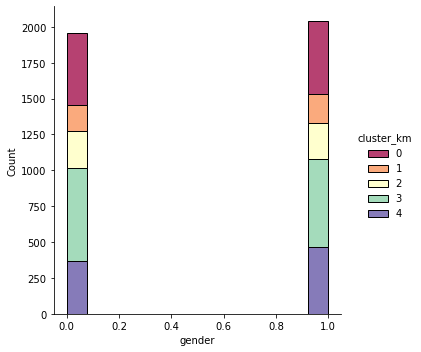

<Figure size 1080x432 with 0 Axes>

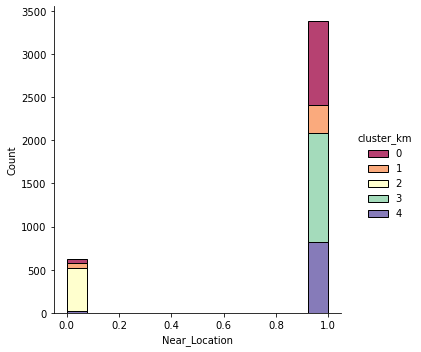

<Figure size 1080x432 with 0 Axes>

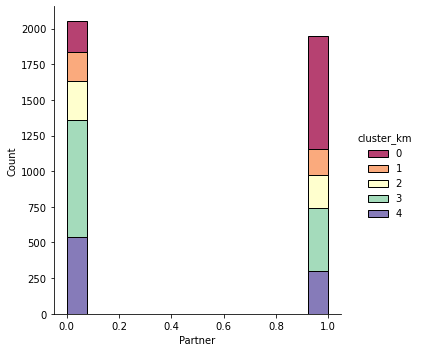

<Figure size 1080x432 with 0 Axes>

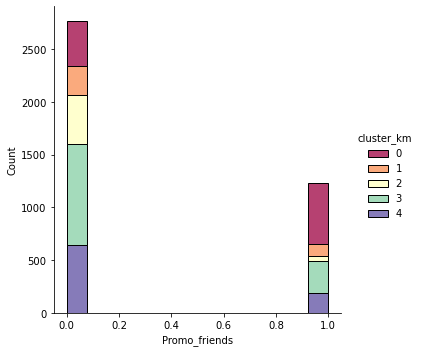

<Figure size 1080x432 with 0 Axes>

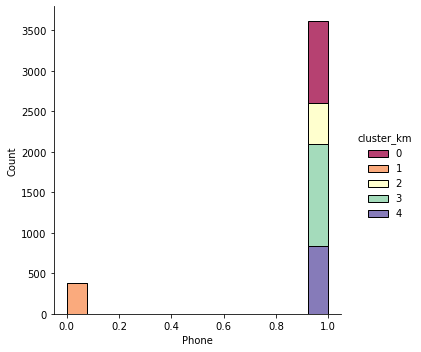

<Figure size 1080x432 with 0 Axes>

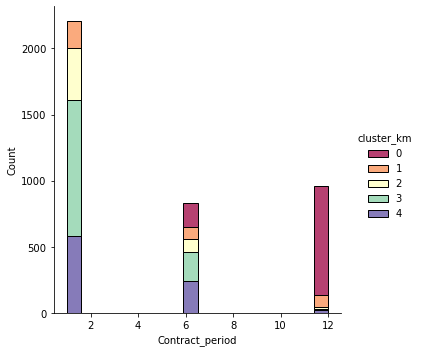

<Figure size 1080x432 with 0 Axes>

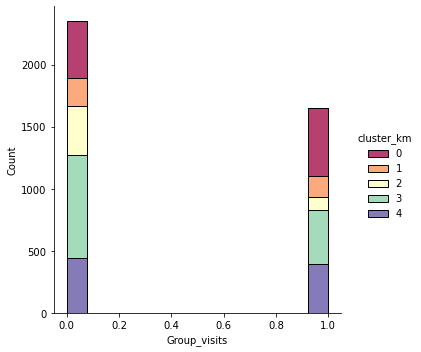

<Figure size 1080x432 with 0 Axes>

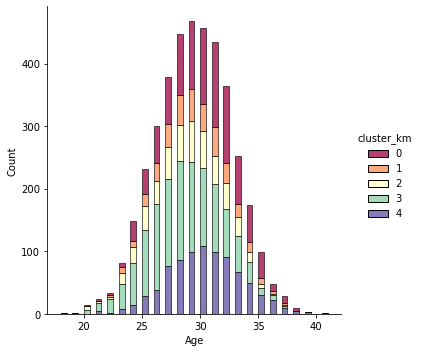

<Figure size 1080x432 with 0 Axes>

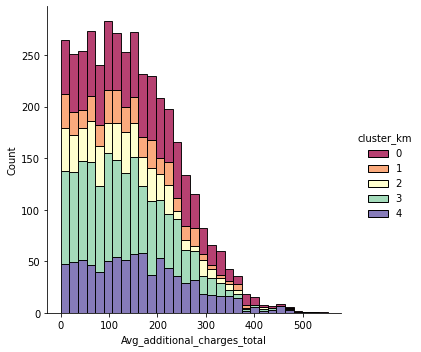

<Figure size 1080x432 with 0 Axes>

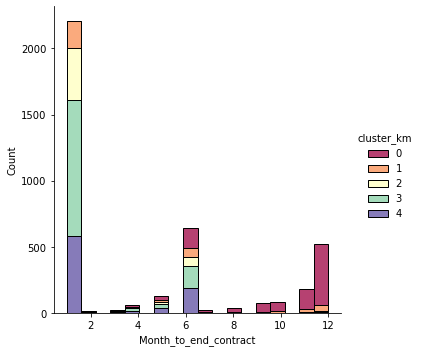

<Figure size 1080x432 with 0 Axes>

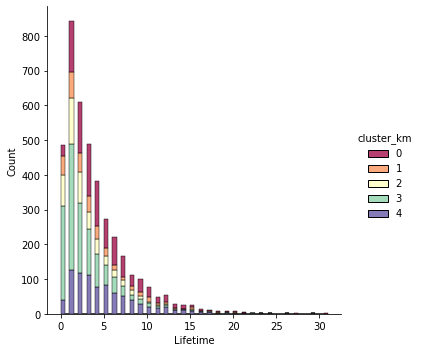

<Figure size 1080x432 with 0 Axes>

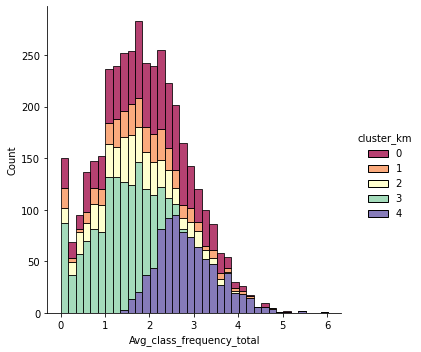

<Figure size 1080x432 with 0 Axes>

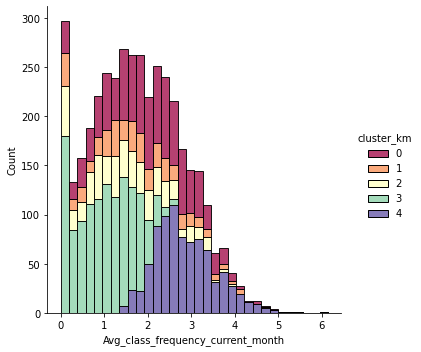

<Figure size 1080x432 with 0 Axes>

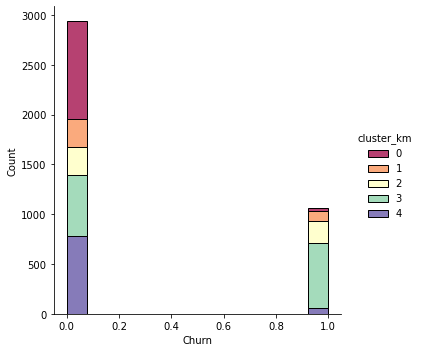

<Figure size 1080x432 with 0 Axes>

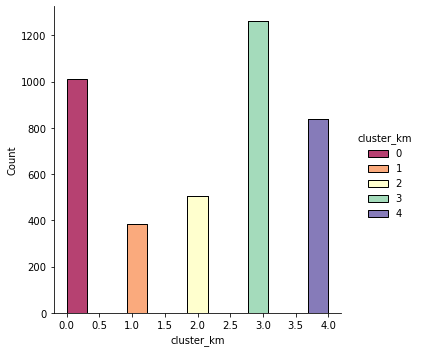

In [13]:
for col in gym_churn.columns:
    plt.figure(figsize=(15,6))
    sns.displot(x=gym_churn[col],
                hue='cluster_km',
                data=gym_churn,
                palette='Spectral',
                multiple='stack');

В каждом кластере присутствуют и мужчины и женщины, так же в каждой группе есть  сотрудники компании-партнёра, клиенты использовавшие промо-код, посещающие групповые занятия  клуба и не являющиеся таковыми. В первый кластер не попали клиенты, заключившие контракт на срок менее полугода, в других группах встречаются клиенты с всеми возможными сроками абонементов. Средняя частота посещений у 4 группы самая низкая, чаще ходят в зал клиенты 5 группы.  В 2 кластер попали клиенты без указанных контактных данных в анкете, во всех остальных кластерах есть сведения о номерах телефонов, что можно использовать, например, для клиентов 4 группы, у которых максимальный отток за последний месяц, для информирования о новый промо и рекламы клуба.

### Вывод.

В ходе анализа было выявлено: 


1. В данных представлено 4000 наблюдений и 14 полей - 13 признаков и целевая переменная Churn, указывающая на факт оттока в текущем месяце. 
2. Клиенты продолжающие ходить в клуб имеют абонементы в среднем сроком на 6 месяцев, в то время в отток ушли те, у кого средний показатель длительности текущего абонемента равен 1,7. Более 45% действующих клиентов посещают групповые занятия, тот же показатель доли у клиентов покинувших клуб равен 26,8%. Средняя частота посещений в два раза больше у клиентов оставшихся, чем у тех, которые ушли в отток. Так же стоит отметить что пол и локация никак не влияет на отток клиентов.
3. Соотношение, имеющих партнерство и без него у клиентов оставшихся в клубе практически равное, а у клиентов попавших в отток нет, так практически вдвое больше клиентов, не имеющих партнерских связей с клубом. В обоих группах преобладают клиенты, купившие абономент сроком на 1 месяц, но в группе с оттоком их более 75%. Чаще всего в отток попадают клиенты, у который осталось менее двух месяцев до окончания абонемента.
4. В сравнении значений метрик логистическая регрессия более интерпретируемая модель, чем случайный лес. Доля правильных ответов в модели регрессии равна 93%, а в модели случайного леса 92%. Метрики точности (precision) и полноты (recall) так же в регресии показывают большую точность. Поэтому можно сделать вывод, что модель Логистической регресии показала себя лучше на основании метрик.
5. Методом агломеративная иерархическая кластеризация что можно выделить 5 кластеров.
6. При деление клиентов на кластеры методом K-Means, во всех кластерах доля мужчин и женщин практически одинаковая и делится в равной пропорции. В 3 кластер попали клиенты, которые не привязанные к клубу территориально, в остальных группах доля клиентов проживанющих или работающих в районе, где находится фитнес-центр 86% и выше. Менее 8% клиентов в 3 группе использовали промо-код для первичной записи в зал, а в первом кластере таких клиентов более 50%. В первоую группу попали клиенты с более длительным сроком действия абонемента. Средний возраст во всех кластерах приблизительно одинаков и варьируется от 28 до 30 лет. Так же стоит отметить, что клиенты 1 и 5 групп тратят в среднем больше, чем клиенты в остальных кластерах.
7. Минимальная доля отток равная 2,7% у первой группы, так же незначительный отток у 5 группы равный 6,8%. Самый большой отток у 4 группы, половина клиентов покинула клуб.
8. В каждом кластере присутствуют и мужчины и женщины, так же в каждой группе есть сотрудники компании-партнёра, клиенты использовавшие промо-код, посещающие групповые занятия клуба и не являющиеся таковыми. В первый кластер не попали клиенты, заключившие контракт на срок менее полугода, в других группах встречаются клиенты с всеми возможными сроками абонементов. Средняя частота посещений у 4 группы самая низкая, чаще ходят в зал клиенты 5 группы. В 2 кластер попали клиенты без указанных контактных данных в анкете, во всех остальных кластерах есть сведения о номерах телефонов, что можно использовать, например, для клиентов 4 группы, у которых максимальный отток за последний месяц, для информирования о новый промо и рекламы клуба.

**Рекомендации для стратегии взаимодействия с клиентами и их удержания:**

1. На основании анализа были сделаны выводы, что 50% клиентов с абонементом длительностью 1 месяц попадают в отток, стоит рассмотреть варианты удержания таких клиентов, специальных предложений для них и скидок на продление. Либо увеличить минимальный срок абонемента в клубе, например, от 3 месяцев.
2. Необходимо проработать стратегию информирования клиентов о новых промо и акциях, а также напоминания о продлении абонементов за несколько месяцев.
3. Клиенты, являющиеся сотрудниками компании-партнёра клуба реже покидают клуб, стоит рассмотреть увеличение партнерских отношений с новыми компаниями для привлечения их сотрудников как новых клиентов клуба.



***